In [316]:
import numpy as np
from scipy.integrate import solve_ivp
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.optim import Adam
from sklearn.model_selection import train_test_split

In [2]:
### Functions for Initial Conditions generation
def generate_fourier_ic(x, n_modes=5, seed=None):
    """
    Generate random Fourier series initial condition
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate coefficients for Fourier series
    a0 = np.random.normal()
    an = np.random.normal(size=n_modes)
    bn = np.random.normal(size=n_modes)
    
    # Compute the Fourier series
    series = a0 + sum(an[i] * np.cos((i+1) * x) + bn[i] * np.sin((i+1) * x) for i in range(n_modes))
    
    # Normalize to [-1, 1]
    series = (series - np.min(series)) / (np.max(series) - np.min(series)) * 2 - 1
    
    return series

def generate_gmm_ic(x, n_components=None, seed=None):
    """
    Generate a Gaussian Mixture Model initial condition.
    """
    if seed is not None:
        np.random.seed(seed)
    
    if n_components is None:
        n_components = np.random.randint(2, 6)
    # Generate random means, variances, and weights
    means = np.random.uniform(0, 2 * np.pi, n_components)
    variances = np.random.uniform(0.1, 0.5, n_components)
    weights = np.random.dirichlet(np.ones(n_components), size=1)[0]
    
    # Compute GMM
    gmm = np.zeros_like(x)
    for i in range(n_components):
        gmm += weights[i] * np.exp(-0.5 * ((x - means[i]) ** 2) / variances[i])
    
    # Normalize to [-1, 1]
    gmm = (gmm - np.min(gmm)) / (np.max(gmm) - np.min(gmm)) * 2 - 1
    
    return gmm

def generate_piecewise_ic(x, n_pieces=None, seed=None):
    """
    Generate piecewise linear initial condition.
    """
    if seed is not None:
        np.random.seed(seed)
    
    if n_pieces is None:
        n_pieces = np.random.randint(3, 7)
    
    # Generate breakpoints
    breakpoints = np.sort(np.random.choice(x, n_pieces, replace=False))
    
    # Generate values at breakpoints
    values = np.random.uniform(-1, 1, n_pieces)
    
    # Create piecewise linear function
    piecewise_func = np.interp(x, breakpoints, values)
    
    # Add occasional discontinuities
    discontinuities = np.random.choice([True, False], size=n_pieces, p=[0.2, 0.8])
    for i, discontinuous in enumerate(discontinuities):
        if discontinuous and i < n_pieces - 1:
            piecewise_func[np.logical_and(x >= breakpoints[i], x < breakpoints[i+1])] += np.random.uniform(-0.5, 0.5)
    
    return piecewise_func

In [3]:
### Allen Cahn rhs computation 
def allen_cahn_rhs(t, u, epsilon, x_grid):
    """Implement Allen-Cahn equation RHS:
        ∂u/∂t = Δu - (1/ε²)(u³ - u)
    """
    dx = x_grid[1] - x_grid[0]
    
    # Compute Laplacian (Δu) with periodic boundary conditions
    laplacian_u = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2
    
    # Compute nonlinear term -(1/ε²)(u³ - u)
    nonlinear_term = -(1 / epsilon**2) * (u**3 - u)
    
    # Return full RHS
    return laplacian_u + nonlinear_term

In [307]:
### Layer and Model classes

# Fourier Layer
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        """
        1D Fourier layer. FFT -> linear transform ->Inverse FFT
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)
 
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :self.modes1] = self.compl_mul1d(x_ft[:, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))

        return x
    
# Fourier Neural Operator block
class FNOBlock(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.spectral_conv  = SpectralConv1d(width, width, modes)
        self.pointwise_conv = nn.Conv1d(width, width, 1)
        self.norm = nn.BatchNorm1d(width)

    # combine spectral and linear layer
    def forward(self, x):
        residual = x
        x = self.spectral_conv(x)
        x = self.pointwise_conv(x)
        x = self.norm(x)
        x = F.relu(x)
        return x + residual

# Time / Epsilon Embedding
class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.linear = nn.Linear(in_features=1, out_features=embedding_dim)
        self.activation = nn.ReLU()

    def forward(self, t):
        # t shape: (batch_size, 1)
        t = t.unsqueeze(1)
        t_emb = self.linear(t)
        t_emb = self.activation(t_emb)
        # return shape: (batch_size, embedding_dim)
        return t_emb

class FILM(torch.nn.Module):
    def __init__(self,
                channels,
                use_bn = True):
        super(FILM, self).__init__()
        self.channels = channels

        self.inp2scale = nn.Linear(in_features=1, out_features=channels, bias=True)
        self.inp2bias = nn.Linear(in_features=1, out_features=channels, bias=True)

        self.inp2scale.weight.data.fill_(0)
        self.inp2scale.bias.data.fill_(1)
        self.inp2bias.weight.data.fill_(0)
        self.inp2bias.bias.data.fill_(0)

        if use_bn:
          self.norm = nn.BatchNorm1d(channels)
        else:
          self.norm = nn.Identity()

    def forward(self, x, time):
        #return x

        x = self.norm(x)
        # Reshape time to have the same batch size as x
        time  = time[:,0].reshape(-1, 1).type_as(x)
        scale = self.inp2scale(time)
        bias  = self.inp2bias(time)
        # Expand scale and bias to match the dimensions of x
        scale = scale.unsqueeze(2).expand(-1, -1, x.shape[-1]) # Expand to match sequence length
        bias = bias.unsqueeze(2).expand(-1, -1, x.shape[-1])  # Expand to match sequence length
        # print("BN shapes (scale, bias, x): ", scale.shape, bias.shape, x.shape)
        return x * scale + bias


class AllenCahnFNO(nn.Module):
    def __init__(self, modes, width):
        super(AllenCahnFNO, self).__init__()

        self.modes = modes
        self.width = width

        # Input layers
        self.linear_p = nn.Linear(2, self.width)  # Include time embedding in the input
        
        # Spectral convolution layers
        self.spect1 = SpectralConv1d(self.width, self.width, self.modes)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes)
        self.spect4 = SpectralConv1d(self.width, self.width, self.modes)

        # Linear layers
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)
        self.lin3 = nn.Conv1d(self.width, self.width, 1)
        
        # FILM layers for time embedding
        self.bn1 = FILM(channels=self.width)
        self.bn2 = FILM(channels=self.width)
        self.bn3 = FILM(channels=self.width)
        self.bn4 = FILM(channels=self.width)
        self.bn5 = FILM(channels=self.width)
        self.bn6 = FILM(channels=self.width)

        # Output layers
        self.linear_q = nn.Linear(self.width, 32) 
        self.output_layer = nn.Linear(32, 1)

        # Activation
        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer, bn1, bn2, time, eps):
        """Applies a Fourier layer followed by a convolution."""
        x = spectral_layer(x) + conv_layer(x)
        x = bn1(x, time)
        x = bn2(x, eps)
        return self.activation(x)

    def forward(self, x, time, epsilon):
        """
        Forward pass:
        - x: (batch_size, n_points, 2) containing initial condition and spatial coordinates.
        - time: (batch_size, 1) containing the time point
        - epsilon: (batch_size, 1) containing the epsilon value
        """
        # Initial projection
        time = time.unsqueeze(-1)
        epsilon = epsilon.unsqueeze(-1)
        x = self.linear_p(x.float())  
        x = x.permute(0, 2, 1)    #(batch_size, 2, n_points)

        # Apply Fourier layers with FILM conditioning
        x = self.fourier_layer(x, self.spect1, self.lin0, self.bn1, self.bn2, time, epsilon)
        x = self.fourier_layer(x, self.spect2, self.lin1, self.bn3, self.bn4, time, epsilon)
        x = self.fourier_layer(x, self.spect3, self.lin2, self.bn5, self.bn6, time, epsilon)

        # Prepare for output
        x = x.permute(0, 2, 1)  #(batch_size, n_points, 2)
        x = self.linear_q(x)
        x = self.output_layer(x)  
        return x


In [ ]:
# Model initialization
model = AllenCahnFNO(modes=65, width=64) 

# Sample data
batch_size = 32
x_size = 128
u = torch.randn(batch_size, x_size)
x_grid = torch.linspace(-1, 1, x_size).unsqueeze(0).expand(batch_size, -1)
x = torch.stack((u, x_grid), dim=-1)
eps = torch.randn(batch_size, 1)
t = torch.ones(batch_size, 1)


print("\nshape x:   ", x.shape,
      "\nshape eps: ", eps.shape,
      "\nshape t:   ", t.shape)
# Forward pass
output = model(x, eps, t)  
print("Output shape: ", output.shape)


shape x:    torch.Size([32, 128, 2]) 
shape eps:  torch.Size([32, 1]) 
shape t:    torch.Size([32, 1])
Output shape:  torch.Size([32, 128, 1])


In [333]:
# Define parameters
n_samples = 150
epsilon_values = [0.15, 0.10, 0.05]
x_grid = np.linspace(-1, 1, x_size)
t_max = 0.05
t_eval = np.linspace(0, t_max, 5)

# Generate and save datasets
for epsilon in epsilon_values:
    dataset = np.zeros((n_samples, len(t_eval), len(x_grid)))
    
    for i in range(50):
        # Generate initial condition with Gaussian Mixture Model
        u0 = generate_gmm_ic(x_grid, seed=i)
        sol = solve_ivp(
            allen_cahn_rhs,
            t_span=(t_eval[0], t_eval[-1]),
            y0=u0,
            t_eval=t_eval,
            args=(epsilon, x_grid),
            method='RK45',
            rtol=1e-6,
            atol=1e-6
        )
        dataset[i] = sol.y.T
    
    for i in range(50, 100):
        # Generate initial condition with Fourier series
        u0 = generate_fourier_ic(x_grid, seed=i)
        sol = solve_ivp(
            allen_cahn_rhs,
            t_span=(t_eval[0], t_eval[-1]),
            y0=u0,
            t_eval=t_eval,
            args=(epsilon, x_grid),
            method='RK45',
            rtol=1e-6,
            atol=1e-6
        )
        dataset[i] = sol.y.T
    
    for i in range(100, 150):
        # Generate initial condition with piecewise linear function
        u0 = generate_piecewise_ic(x_grid, seed=i)
        sol = solve_ivp(
            allen_cahn_rhs,
            t_span=(t_eval[0], t_eval[-1]),
            y0=u0,
            t_eval=t_eval,
            args=(epsilon, x_grid),
            method='RK45',
            rtol=1e-6,
            atol=1e-6
        )
        dataset[i] = sol.y.T
    
    # Save dataset to file
    np.save(f'train_dataset_epsilon_{epsilon:.2f}.npy', dataset)

In [334]:
# Load the data
data_A  = np.load('train_dataset_epsilon_0.15.npy')
data_B  = np.load('train_dataset_epsilon_0.10.npy')
data_C  = np.load('train_dataset_epsilon_0.05.npy')

# Split the data
train_data_A, val_data_A  = train_test_split(data_A, test_size=0.2, random_state=42)
train_data_B, val_data_B  = train_test_split(data_B, test_size=0.2, random_state=42)
train_data_C, val_data_C  = train_test_split(data_C, test_size=0.2, random_state=42)

# Create dictionaries for train and validation data
train_data     = {epsilon_values[0]: train_data_A, epsilon_values[1]: train_data_B, epsilon_values[2]: train_data_C}
val_data       = {epsilon_values[0]: val_data_A,   epsilon_values[1]: val_data_B,   epsilon_values[2]: val_data_C}
train_val_data = {epsilon_values[0]: data_A,       epsilon_values[1]: data_B,       epsilon_values[2]: data_C}

time_points = np.linspace(0,t_max,5)


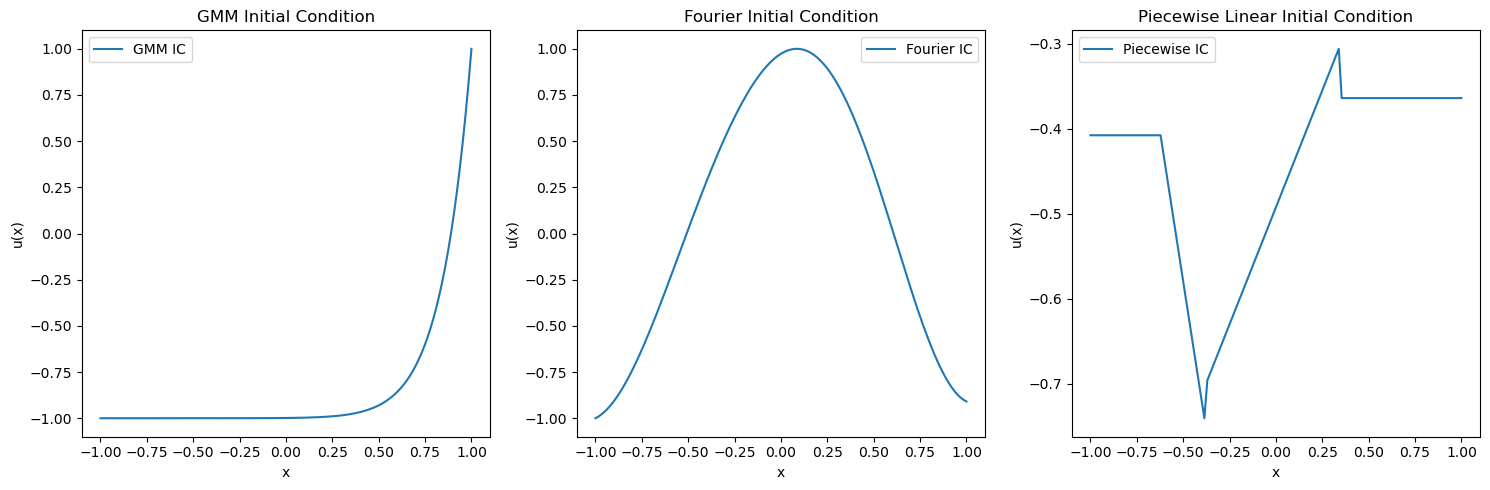

In [323]:
# Generate x values
x_values = np.linspace(-1, 1, x_size)

# Generate initial conditions
gmm_ic = generate_gmm_ic(x_values, seed=0)
fourier_ic = generate_fourier_ic(x_values, seed=0)
piecewise_ic = generate_piecewise_ic(x_values, seed=0)

# Plot the initial conditions
plt.figure(figsize=(15, 5))

# GMM initial condition
plt.subplot(1, 3, 1)
plt.plot(x_values, gmm_ic, label='GMM IC')
plt.title('GMM Initial Condition')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

# Fourier initial condition
plt.subplot(1, 3, 2)
plt.plot(x_values, fourier_ic, label='Fourier IC')
plt.title('Fourier Initial Condition')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

# Piecewise initial condition
plt.subplot(1, 3, 3)
plt.plot(x_values, piecewise_ic, label='Piecewise IC')
plt.title('Piecewise Linear Initial Condition')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

plt.tight_layout()
plt.show()

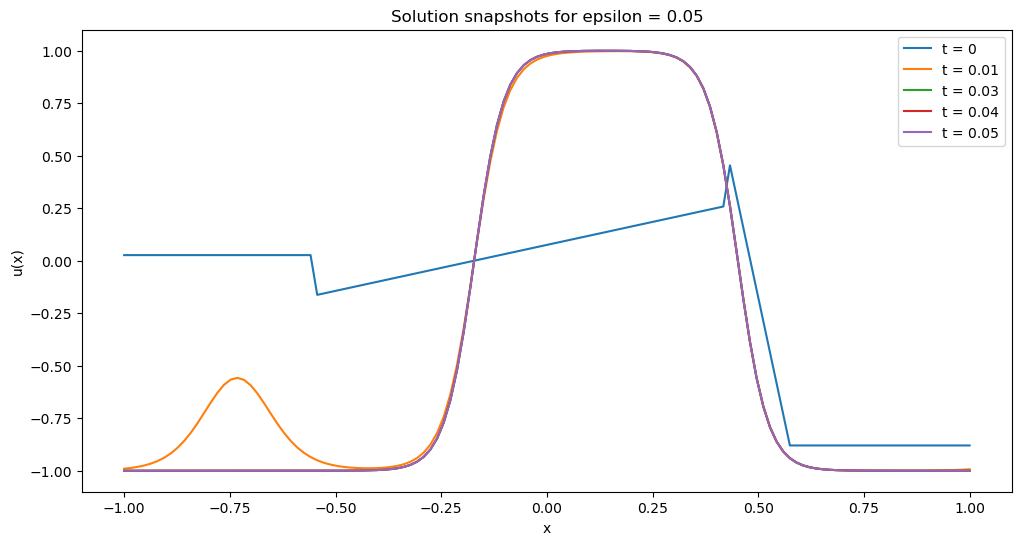

In [337]:
# Plot the snapshots for each epsilon value
plot_epsilon = epsilon_values[2]
dataset = val_data[plot_epsilon]

# Select a sample from the dataset
sample_idx = 10
sample = dataset[sample_idx]

# Extract the initial condition and the solution at different time points
u_initial = sample[0]
u_snapshots = sample[1:]

# Plot the snapshots
plt.figure(figsize=(12, 6))
plt.plot(x_values, u_initial, label='t = 0')
for i, u_t in enumerate(u_snapshots):
    plt.plot(x_values, u_t, label=f't = {time_points[i+1]:.2f}')

plt.xlabel('x')
plt.ylabel('u(x)')
plt.title(f'Solution snapshots for epsilon = {plot_epsilon}')
plt.legend()
plt.savefig('solution_example.png', format='png') 
plt.show()

In [338]:
n_train = 120 # number of samples in each epsilon-dataset (train_data // train_val_data // val_data)
# Create training data pairs
input_data  = []
output_data = []
time_diff   = []
epsilon_value = []
x_values    = np.linspace(-1, 1, 128)
x_values    = torch.tensor(x_values, dtype=torch.float64)

len_time = len(time_points)
for eps in epsilon_values:
    train_data_current = train_data[eps]
    for i in range(n_train):
        for j in range(len_time):
            for k in range(j + 1, len_time):
                # input: u(t=times[j]) and x coordinates
                input_func = torch.tensor(train_data_current[i, j, :])
                input_func = torch.stack([input_func, x_values], dim=-1)

                # output: u(t=times[k]) and x coordinates
                output_func = torch.tensor(train_data_current[i, k, :])
                output_func = torch.stack([output_func, x_values], dim=-1)

                # time difference
                time_difference = time_points[k] - time_points[j]

                input_data.append(input_func)
                output_data.append(output_func)
                time_diff.append(time_difference)
                epsilon_value.append(eps)

# convert to tensors
input_data    = torch.stack(input_data)
output_data   = torch.stack(output_data)
time_diff     = torch.tensor(time_diff, dtype=torch.float64)
epsilon_value = torch.tensor(epsilon_value, dtype=torch.float64)


print("\nInput data shape:      ",input_data.shape)
print("\nOutput data shape:     ",output_data.shape)
print("\nTime difference shape: ",time_diff.shape)
print("\nEpsilon values shape:  ",epsilon_value.shape)

# Create training DataLoader
batch_size = 32
training_set = DataLoader(TensorDataset(input_data, time_diff, epsilon_value, output_data), batch_size=batch_size, shuffle=True)




Input data shape:       torch.Size([3600, 128, 2])

Output data shape:      torch.Size([3600, 128, 2])

Time difference shape:  torch.Size([3600])

Epsilon values shape:   torch.Size([3600])


In [339]:
### VALIDATION DATA
n_val = 30 # number of samples in each epsilon-dataset (train_data // train_val_data // val_data)
# Create training data pairs
input_data  = []
output_data = []
time_diff   = []
epsilon_value = []
x_values    = np.linspace(-1, 1, 128)
x_values    = torch.tensor(x_values, dtype=torch.float64)

len_time = len(time_points)
for eps in epsilon_values:
    val_data_current = val_data[eps]
    for i in range(n_val):
        for j in range(len_time):
            for k in range(j + 1, len_time):
                # input: u(t=times[j]) and x coordinates
                input_func = torch.tensor(val_data_current[i, j, :])
                input_func = torch.stack([input_func, x_values], dim=-1)

                # output: u(t=times[k]) and x coordinates
                output_func = torch.tensor(val_data_current[i, k, :])
                output_func = torch.stack([output_func, x_values], dim=-1)

                # time difference
                time_difference = time_points[k] - time_points[j]

                input_data.append(input_func)
                output_data.append(output_func)
                time_diff.append(time_difference)
                epsilon_value.append(eps)

# convert to tensors
input_data  = torch.stack(input_data)
output_data = torch.stack(output_data)
time_diff   = torch.tensor(time_diff, dtype=torch.float64)
epsilon_value = torch.tensor(epsilon_value, dtype=torch.float64)


print("\nInput data shape:      ",input_data.shape)
print("\nOutput data shape:     ",output_data.shape)
print("\nTime difference shape: ",time_diff.shape)
print("\nEpsilon values shape:  ",epsilon_value.shape)

# Create training DataLoader
batch_size = 32
validation_set = DataLoader(TensorDataset(input_data, time_diff, epsilon_value, output_data), batch_size=batch_size, shuffle=True)




Input data shape:       torch.Size([900, 128, 2])

Output data shape:      torch.Size([900, 128, 2])

Time difference shape:  torch.Size([900])

Epsilon values shape:   torch.Size([900])


In [340]:
# hyperparameters
learning_rate = 0.001
epochs = 10
step_size = 1 #50
gamma = 0.5
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# loss function
l = torch.nn.MSELoss()
freq_print = 1

# training loop
for epoch in range(epochs):
    train_mse = 0.0
    train_relative_l2 = 0.0
    for step, (input_batch, time_diff_batch, epsilon_value_batch, output_batch) in enumerate(training_set):
        # print("input_batch shape:     ", input_batch.shape)
        # print("time_diff_batch shape: ", time_diff_batch.shape)
        optimizer.zero_grad()
        # Ensuring everything is float
        input_batch       = input_batch.float()
        time_diff_batch   = time_diff_batch.float()
        epsilon_val_batch = epsilon_val_batch.float()
        output_batch      = output_batch.float()

        output_pred_batch   = model(input_batch, time_diff_batch, epsilon_value_batch)
        actual_output_batch = output_batch[:, :, 0:1]
        loss_f = l(output_pred_batch, actual_output_batch).float()
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)
    scheduler.step()
    with torch.no_grad():
        model.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, time_diff_batch, epsilon_value_batch, output_batch) in enumerate(validation_set):
            # ensure all floats
            input_batch = input_batch.float()
            time_diff_batch = time_diff_batch.float()
            epsilon_val_batch = epsilon_val_batch.float()
            output_batch = output_batch.float()
            
            output_pred_batch = model(input_batch, time_diff_batch, epsilon_value_batch)
            correct_output_batch = output_batch[:, :, 0:1]

            loss_f = (torch.mean((output_pred_batch - correct_output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(validation_set)
    if epoch % freq_print == 0:
        print("### Epoch:", epoch, " ### Train Loss:", train_mse, " ### Relative L2 Test Norm:", test_relative_l2)



### Epoch: 0  ### Train Loss: 0.02482712624050611  ### Relative L2 Test Norm: 21.54982385964229
### Epoch: 1  ### Train Loss: 0.01991006871273296  ### Relative L2 Test Norm: 19.813491525321172
### Epoch: 2  ### Train Loss: 0.017813264408799927  ### Relative L2 Test Norm: 19.75092177555479
### Epoch: 3  ### Train Loss: 0.017024653889568506  ### Relative L2 Test Norm: 19.870211371060076
### Epoch: 4  ### Train Loss: 0.016582504392857047  ### Relative L2 Test Norm: 18.876686918324438
### Epoch: 5  ### Train Loss: 0.016304119160415326  ### Relative L2 Test Norm: 19.54895414155105
### Epoch: 6  ### Train Loss: 0.01617036302021779  ### Relative L2 Test Norm: 18.912767541819605
### Epoch: 7  ### Train Loss: 0.016090375066331004  ### Relative L2 Test Norm: 18.884733331614527
### Epoch: 8  ### Train Loss: 0.016056882180438367  ### Relative L2 Test Norm: 19.208345610519935
### Epoch: 9  ### Train Loss: 0.016045640647180576  ### Relative L2 Test Norm: 19.281369735454692


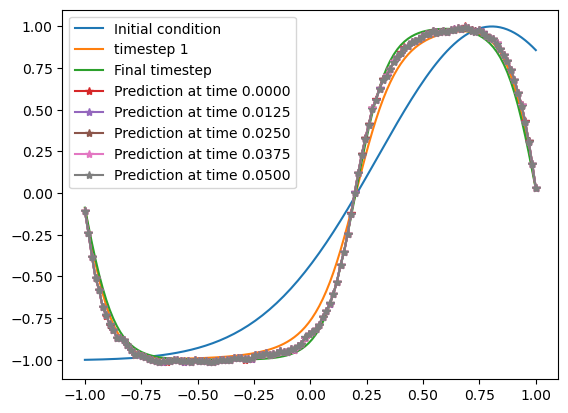

In [341]:
### Try out the trained model
example_dataset = train_val_data[0.1]
sample = example_dataset[1,:,:]
grid = torch.tensor(np.linspace(-1, 1, 128))
time_points = np.linspace(0,t_max,5)
# plot sample
plt.plot(grid, sample[0,:],label='Initial condition')
plt.plot(grid, sample[1,:],label='timestep 1')
plt.plot(grid, sample[-1,:],label='Final timestep')

for time in time_points:
    model.eval()
    with torch.no_grad():
        x = torch.tensor(sample[0,:])
        x = torch.stack([x, grid], dim=-1).unsqueeze(0)
        eps = torch.tensor([0.1])
        t_diff = torch.tensor([time])
        pred = model(x, eps, t_diff)
        plt.plot(grid, pred[0,:,0], '-*', label=f"Prediction at time {time:.4f}")
plt.legend()
plt.show()
          
        